In [1]:
import sympy as sp
from sympy.physics.mechanics import dynamicsymbols, init_vprinting

init_vprinting()

<img src="pendulum_sketch.png" alt="pendulum" width="300"/>

$$
x_{m_1} = \ell_1 \sin(\theta_1)  ~~~~~~~~~~~~~~~~~~~~~~~ y_{m_1} = - \ell_1 cos(\theta_1)
\newline
\dot x_{m_1} = \ell_1 \dot \theta_1 cos(\theta_1) ~~~~~~~~~~~~~~~~~~~~~~~ \dot y_{m_1} = \ell_1 \dot \theta_1 (sin \theta_1)
$$

$$
x_{m_2} = \ell_1 \sin(\theta_1) + \ell_2 \sin(\theta_2)  ~~~~~~~~~~~~~~~~~~~~~~~ y_{m_2} = - \ell_1 cos(\theta_1) - \ell_2 cos(\theta_2)
\newline
\dot x_{m_2} = \ell_1 \dot \theta_1 cos(\theta_1) + \ell_2 \dot \theta_2 cos(\theta_2) ~~~~~~~~~~~~~~~~~~~~~~~ \dot y_{m_2} = \ell_1 \dot \theta_1 (sin \theta_1) + \ell_2 \dot \theta_2 (sin \theta_2)
$$

$$
T = \frac{1}{2} m_1 v_1^2 + \frac{1}{2} m_2 v_2^2 ~~~~~~~~~~~~~~~~~~~~~~~ V = m_1 g h_1 + m_2 g h_2
$$

$$
T = \frac{1}{2} m_1 (\dot x_{m_1}^2 + \dot y_{m_1}^2) + \frac{1}{2} m_2 (\dot x_{m_2}^2 + \dot y_{m_2}^2) ~~~~~~~~~~~~~~~~~~~~~~~ V = m_1 g y_{m_1} + m_2 g y_{m_2}
$$

In [32]:
# Create symbolic variables
m_1, m_2, ell_1, ell_2, g, t = sp.symbols('m_1, m_2, ell_1, ell_2, g, t')
theta_1, theta_2 = dynamicsymbols('theta_1, theta_2')

# Define xm1, ym1, xm2, ym2
xm1 = ell_1 * sp.sin(theta_1)
ym1 = -ell_1 * sp.cos(theta_1)
xm2 = xm1 + ell_2 * sp.sin(theta_2)
ym2 = ym1 - ell_2 * sp.cos(theta_2)

# Derivatives of xm1, ym1, xm2, ym2
xm1_dot = sp.diff(xm1, t)
ym1_dot = sp.diff(ym1, t)
xm2_dot = sp.diff(xm2, t)
ym2_dot = sp.diff(ym2, t)

theta_1_dot = sp.diff(theta_1, t)
theta_2_dot = sp.diff(theta_2, t)
theta_1_ddot = sp.diff(theta_1_dot, t)
theta_2_ddot = sp.diff(theta_2_dot, t)

# Lagrangian
T = sp.Rational(1,2) * m_1 * (xm1_dot**2 + ym1_dot**2) + sp.Rational(1,2) * m_2 * (xm2_dot**2 + ym2_dot**2)
V = m_1 * g * ym1 + m_2 * g * ym2

L = T - V

In [20]:
print('Lagrangian:')
L.simplify()

Lagrangian:


$$
p_{\theta_1} = \dfrac{\partial L}{\partial \dot \theta_1}, ~
p_{\theta_2} = \dfrac{\partial L}{\partial \dot \theta_2}
$$

In [24]:
# Canonical Momentum
p_theta_1 = sp.diff(L, theta_1_dot)
p_theta_2 = sp.diff(L, theta_2_dot)

In [29]:
p_theta_1.simplify(), p_theta_2.simplify()

$$
\dfrac{d}{dt} \bigg( \dfrac{\partial L}{\partial \dot q} \bigg) - \dfrac{\partial L}{\partial q} = 0
$$

$$
\dfrac{d}{dt} \bigg( \dfrac{\partial L}{\partial \dot \theta_i} \bigg) - \dfrac{\partial L}{\partial \theta_i} = 0
\implies
\dfrac{d p_{\theta_i}}{dt} - \dfrac{\partial L}{\partial \theta_i} = 0
$$

In [30]:
# Euler-Lagrange Equations
eq1 = sp.Eq(sp.diff(p_theta_1, t) - sp.diff(L, theta_1), 0)
eq2 = sp.Eq(sp.diff(p_theta_2, t) - sp.diff(L, theta_2), 0)

In [31]:
eq1.simplify(), eq2.simplify()

In [42]:
# Solve Equations
solution1 = sp.solve(eq1, theta_1_ddot)[0]
solution2 = sp.solve(eq2, theta_2_ddot)[0]

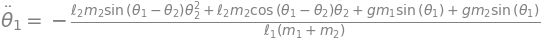

In [45]:
sp.Eq(theta_1_ddot, solution1)

In [46]:
sp.Eq(theta_2_ddot, solution2)

In [51]:
# System of ODEs
x = sp.Matrix([theta_1, theta_2, theta_1_dot, theta_2_dot])
x_dot = sp.diff(x,t)
sp.Eq(x_dot, sp.Matrix([theta_1_dot, theta_2_dot, solution1, solution2]))

       ⎡                                         θ₁̇                          
       ⎢                                                                      
       ⎢                                         θ₂̇                          
⎡θ₁̇⎤   ⎢                                                                     
⎢  ⎥   ⎢ ⎛                       2                                            
⎢θ₂̇⎥   ⎢-⎝ell₂⋅m₂⋅sin(θ₁ - θ₂)⋅θ₂̇  + ell₂⋅m₂⋅cos(θ₁ - θ₂)⋅θ₂̈ + g⋅m₁⋅sin(θ₁)
⎢  ⎥ = ⎢──────────────────────────────────────────────────────────────────────
⎢θ₁̈⎥   ⎢                                   ell₁⋅(m₁ + m₂)                    
⎢  ⎥   ⎢                                                                      
⎣θ₂̈⎦   ⎢                                  2                                  
       ⎢              ell₁⋅sin(θ₁ - θ₂)⋅θ₁̇  - ell₁⋅cos(θ₁ - θ₂)⋅θ₁̈ - g⋅sin(θ
       ⎢              ────────────────────────────────────────────────────────
       ⎣                                        ell₂